1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import os
%matplotlib inline

df = pd.read_csv("https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv", index_col=0, header=0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [2]:
df_default = pd.get_dummies(df['default'])
df_student = pd.get_dummies(df['student'])
df_final = pd.concat([df[['balance', 'income']], df_default, df_student], axis=1)
df_final.columns = ['balance', 'income', 'default no', 'default yes', 'student no', 'student yes']
df_final.head()

,balance,income,default no,default yes,student no,student yes
1,729.526495,44361.625074,1.0,0.0,1.0,0.0
2,817.180407,12106.134700,1.0,0.0,0.0,1.0
3,1073.549164,31767.138947,1.0,0.0,1.0,0.0
4,529.250605,35704.493935,1.0,0.0,1.0,0.0
5,785.655883,38463.495879,1.0,0.0,1.0,0.0


3) Make boxplots of all of the variables and a scatter plot of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

/Users/Alex/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  from ipykernel import kernelapp as app


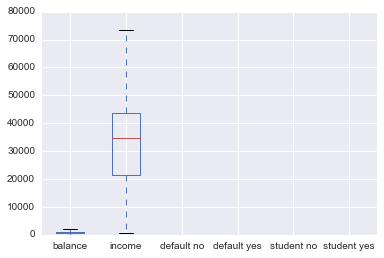

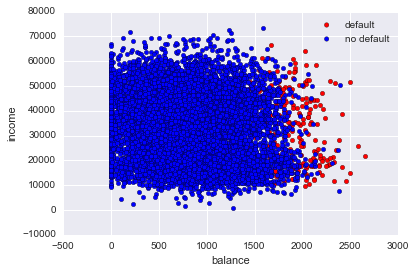

In [3]:
# Boxplot of variables
df_final.boxplot()
plt.show()

# Scatter plot of balance vs. income 
df_default_yes = df_final[df_final['default yes'] == 1.0]
df_default_no = df_final[df_final['default no'] == 1.0]

fig, ax = plt.subplots()
ax.scatter(df_default_yes['balance'], df_default_yes['income'], c='red', label='default')
ax.scatter(df_default_no['balance'], df_default_no['income'], c='blue', label='no default')
plt.xlabel('balance')
plt.ylabel('income')
plt.legend()
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

Area under the ROC curve : 0.960749


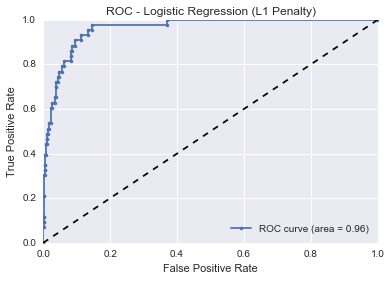

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc

# Create data frame with only balance and income variables
X = df_final.drop(['default yes', 'default no', 'student yes', 'student no'], 1)
y = df_final['default yes']

# Computes the AUC ROC of the classifier
def generate_auc(X, y, clf_class, **kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    
    # Construct training and testing sets
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples / 1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    # Choose SVC classifier
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    print "Area under the ROC curve : %f" % roc_auc
    return fpr, tpr, roc_auc, thresholds

def generate_ROCplot(fpr, tpr, label, roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - %s' % label)
    plt.legend(loc="lower right")
    plt.show()

# Generate ROC for Logistic Regression with L1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X, y, LogisticRegression, C=0.1, penalty='l1')

# Plot ROC
generate_ROCplot(fpr,tpr,'Logistic Regression (L1 Penalty)',roc_auc)

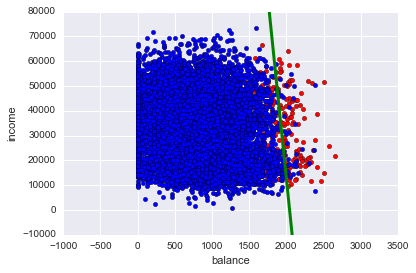

In [5]:
from sklearn.multiclass import OneVsRestClassifier

# Find decision boundary
classifier = OneVsRestClassifier(LogisticRegression(penalty='l1')).fit(X, y)
coef = classifier.coef_
intercept = classifier.intercept_
balance = np.linspace(-500, 3000, 100)
income = -(coef[:, 0] * balance + intercept[:, 0]) / coef[:,1]

# Plot decision boundary overlaid with scatter plot
fig, ax = plt.subplots()
ax.scatter(df_default_yes['balance'], df_default_yes['income'], c='red')
ax.scatter(df_default_no['balance'], df_default_no['income'], c='blue')
plt.plot(balance, income, color='green', label='Decision boundary', linewidth=3)
plt.ylim([-10000, 80000])
plt.xlabel('balance')
plt.ylabel('income')
plt.show()

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

Area under the ROC curve : 0.962295


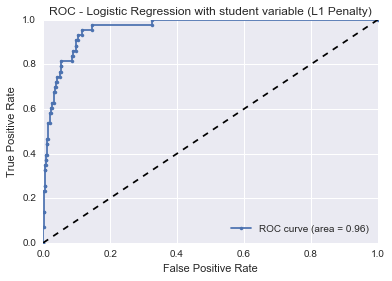

In [6]:
# Data frame with student variables included
X_students = df_final.drop(['default yes', 'default no'], 1)

# Generate ROC for Logistic Regression with L2 penalty and C=0.1
fpr, tpr, roc_auc, thresholds = generate_auc(X_students, y, LogisticRegression, C=0.1, penalty='l1')

# Plot ROC
generate_ROCplot(fpr, tpr, 'Logistic Regression with student variable (L1 Penalty)', roc_auc)

Coefficients for logistic regression using L1 penalty: 

balance: 0.00495755298409
income: -7.98645415049e-06
student no: 0.0
student yes: -0.643705586263


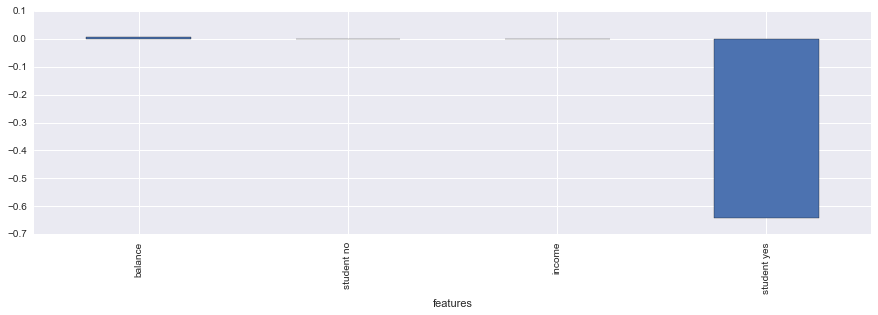

In [7]:
regr = LogisticRegression(C=0.1, penalty='l1')
regr.fit(X_students, y)
dfCoeffs = pd.DataFrame({'features':X_students.columns.values, 'coef':regr.coef_[0]})

print "Coefficients for logistic regression using L1 penalty: \n"
for el in range(4):
    print "%s: %s" % (X_students.columns.values[el], regr.coef_[0][el])

plt.figure(figsize=(15,4))
dfCoeffs2 = dfCoeffs.groupby('features')['coef'].mean()
dfCoeffs2.sort_values(inplace=True)
dfCoeffs2[::-1].plot(kind='bar')
plt.show()

**Answer**

The logistic regression for this question uses L1 penalty (Lasso) instead of Ridge (L2) since the latter gave poor results. The performance of the model with student variables is similar to the model without student variables (from part 4); specifically, the model with student variables had an AUC ROC of 0.962238 while the model without student variables had an AUC ROC of 0.960620. This result makes sense since we can see from the coefficient ranking plot above that the `student yes` and `student no` variables were not important as the L1 penalty assigned coefficients of 0 to each.

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

R^2 values for 5-fold cross-validation using C = 0.1 as regularization parameter: 
 [ 0.97101449  0.97201399  0.971       0.97348674  0.97448724]


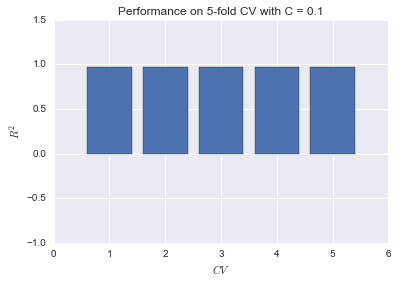

In [8]:
from sklearn.model_selection import cross_val_score

# Run 5-fold cross-validation of Logistic Regression model with L2 penalty and C=0.1
clf = LogisticRegression(C=0.1, penalty='l1')
cv_errors = cross_val_score(clf, X, y, cv=5)
print "R^2 values for 5-fold cross-validation using C = 0.1 as regularization parameter: \n %s" % cv_errors 

# Plot R^2 of 5-fold cross-validation
plt.bar(range(1,6), cv_errors, align='center')
plt.ylim([-1, 1.5])
plt.xlabel('$CV$')
plt.ylabel('$R^2$')
plt.title('Performance on 5-fold CV with C = 0.1')
plt.show()

**Answer**

The model from part 5) generalizes well since the $R^2$ values over the 5 folds are accurate to two decimal places.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision tree - depth 2
clf_2 = DecisionTreeClassifier(max_depth=2)
clf_2 = clf_2.fit(X_train, y_train)
predictions2 = clf_2.predict(X_test)
confusion_matrix2 = sklearn.metrics.confusion_matrix(y_test, predictions2)
accuracy2 = sklearn.metrics.accuracy_score(y_test, predictions2)

# Decision tree - depth 3
clf_3 = DecisionTreeClassifier(max_depth=3)
clf_3 = clf_3.fit(X_train, y_train)
predictions3 = clf_3.predict(X_test)
confusion_matrix3 = sklearn.metrics.confusion_matrix(y_test, predictions3)
accuracy3 = sklearn.metrics.accuracy_score(y_test, predictions3)

# Decision tree - depth 5
clf_5 = DecisionTreeClassifier(max_depth=5)
clf_5 = clf_5.fit(X_train, y_train)
predictions5 = clf_5.predict(X_test)
confusion_matrix5 = sklearn.metrics.confusion_matrix(y_test, predictions5)
accuracy5 = sklearn.metrics.accuracy_score(y_test, predictions5)

print "Decision Tree - Depth 2"
print "True Positive: %s" % confusion_matrix2[0][0]
print "False Positive: %s" % confusion_matrix2[1][0]
print "False Negative: %s" % confusion_matrix2[0][1]
print "True Negative: %s" % confusion_matrix2[1][1]
print "Accuracy: %s" % accuracy2

print "\nDecision Tree - Depth 3"
print "True Positive: %s" % confusion_matrix3[0][0]
print "False Positive: %s" % confusion_matrix3[1][0]
print "False Negative: %s" % confusion_matrix3[0][1]
print "True Negative: %s" % confusion_matrix3[1][1]
print "Accuracy: %s" % accuracy3

print "\nDecision Tree - Depth 5"
print "True Positive: %s" % confusion_matrix5[0][0]
print "False Positive: %s" % confusion_matrix5[1][0]
print "False Negative: %s" % confusion_matrix5[0][1]
print "True Negative: %s" % confusion_matrix5[1][1]
print "Accuracy: %s" % accuracy5


Decision Tree - Depth 2
True Positive: 1922
False Positive: 55
False Negative: 9
True Negative: 14
Accuracy: 0.968

Decision Tree - Depth 3
True Positive: 1916
False Positive: 48
False Negative: 15
True Negative: 21
Accuracy: 0.9685

Decision Tree - Depth 5
True Positive: 1922
False Positive: 52
False Negative: 9
True Negative: 17
Accuracy: 0.9695


**Answer**

Performance for the decision tree classifier is also good. The accuracy is high (around 0.96) for depth 2, 3, and 5 trees. Also, the false positives and false negatives are relatively small.

8) Find the optimal decision tree depth and compute the AUC ROC. 

The optimal decision tree depth is 3


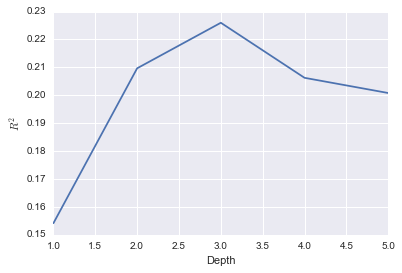

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

# Fit regression model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_errors = []
test_errors = []
scores = []
depths = range(1,6)

for n in depths:
    regr = DecisionTreeRegressor(max_depth=n)
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train, y_train))
    scores.append(regr.score(X_test, y_test))
    
plt.ylabel('$R^2$')
plt.xlabel('Depth')
plt.plot(depths, scores)
test_errors = scores
n_opt = depths[np.argmax(scores)]

print "The optimal decision tree depth is %s" % n_opt

Area under the ROC curve : 0.637000


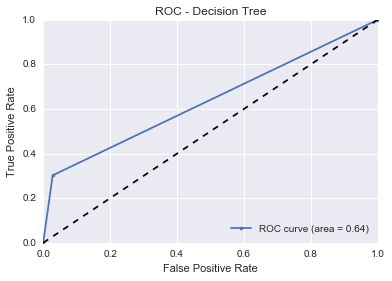

In [11]:
from sklearn.tree import DecisionTreeClassifier

# Generate ROC for Decision Tree Classifier
fpr, tpr, roc_auc, thresholds = generate_auc(X, y, DecisionTreeClassifier)

# Plot ROC
generate_ROCplot(fpr, tpr, 'Decision Tree', roc_auc)